## Test projection matrices over $N$ layers, using a reconstructor that projects onto modes

In [71]:
# Python setup and modules
from __future__ import print_function
import numpy
import sys
import time
numpy.random.seed(int(time.time()%1234))

In [72]:
# plotting
%matplotlib notebook
import matplotlib.pyplot as pyp

In [170]:
# specific modules
import commonSeed
import gradientOperator
import kolmogorov
import modalBasis
import projection
from importlib import reload
reload(projection)
import Zernike

In [359]:
nAzi=3
baseSize=5 # [elements] note that each element(==wavefront grid spacing) could be considered in size 1m for SI
starHeight=None # [m] finite e.g. 15e3 or None==\inf
za=2*(baseSize/4.0)/20.0e3 # [not a usual angle, elements/m] zenith angle
dH=9e3 # [m] spacing of projection layers
Hmax=30e3 # [m] highest projection layer
reps=1000 # number of MC repetitions
#
#}sameGeometry=True # always assume True in this code
#
#
# naive means Tikhonov
# intermediate means 'intermediate layer restriction'
# laplacian means Laplacian approximation
# SVD means avoid direct inversion
regularizationType=['intermediate','laplacian','SVD','naive'][1]
modalPowers=None#{'r':[1,],'ang':[0,1]} # which modes to reconstruct, None means zonal
#
verbose=True

Define the pupil, in `baseSize` units.

In [360]:
mask=(Zernike.anyZernike(1,baseSize,baseSize/2,ongrid=1)
      -Zernike.anyZernike(1,baseSize,baseSize/2/7.0,ongrid=1)*0)
mask=mask.astype(numpy.int32)
nMask=int(mask.sum())

nMask=21


<IPython.core.display.Javascript object>


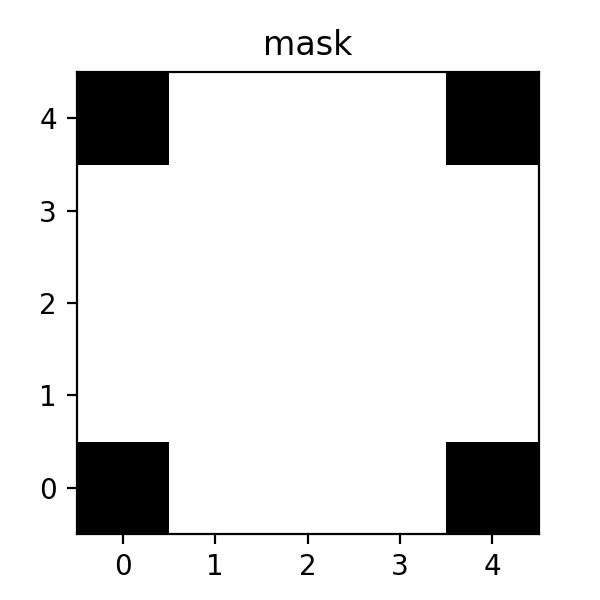

In [361]:
if verbose:
    print("nMask={:d}".format(nMask))
    pyp.figure(1,figsize=(3,3))
    pyp.imshow(mask,cmap='gray',vmax=1,vmin=0)
    pyp.title("mask")

Important variables below,
* Reconstruction geometry object, `reconGeometry`,
* Data geometry object, `actualGeometry`,

* Modal basis for reconstruction, `thisModalBasis`
* Modal coefficients op., `modalCoefficientsM`
* Modal coefficients op. for each direction, `modalCoeffsAllM`,


In [362]:
# angle, 5/20e3 is ~50'' which is ~CANARY 1
# Separation of one sub-ap between regular spacing is at alt,
# |zenith_angle*h*(1,0)-(cos(azi),sin(azi))|=zenith_angle*h*((1-cos)**2.0+sin**2.0)
#=za*h*(2-2cos(azi)), azi=2pi/N
aa=2*numpy.pi*(nAzi**-1.0)
if verbose:
    print("aa, azimuthal angle step={:4.2f} radians".format(aa))
#dH=( za*(2-2*numpy.cos(aa)) )**-1.0*1.0

reconGeometry=projection.projection(
        numpy.floor( numpy.arange(numpy.floor((Hmax/dH)))*dH ),
        [za]*nAzi, numpy.arange(nAzi)*aa, mask, starHeight,
        centrePixelBoundary=True
    )
if verbose:
    print("reconstruction, nLayers={:d}".format(reconGeometry.nLayers))
if modalPowers is None:
    # Cartesian, or zonal
    modalCoefficientsM=numpy.identity(mask.sum())
else:
    # Truly modal
    thisModalBasis=modalBasis.polySinRadAziBasisType1(
          mask, modalPowers['r'],modalPowers['ang'], orthonormalize=0
       )
    modalCoefficientsM=thisModalBasis.modalFunctions # note, not orthogonal
nModes=modalCoefficientsM.shape[0]
if verbose: print("nModes={:d}".format(nModes))
modalCoeffsAllM=numpy.zeros([nModes*nAzi, nMask*nAzi], numpy.float64)
for i in range(nAzi): # nAzi directions modal basis operator
    modalCoeffsAllM[nModes*i:nModes*(i+1),nMask*i:nMask*(i+1)]=modalCoefficientsM

if not reconGeometry.createLayerMasks(): raise ValueError("Eek! (1)")

#}if sameGeometry:
actualGeometry=reconGeometry
print("NOTE: Same geometry assumed")
#}else:
#}   actualGeometry=projection.projection(
#}    [0]+numpy.sort(
#}       numpy.random.uniform(1e3,15e3,size=5) ).astype('i').tolist(),
#}    [za]*nAzi, numpy.arange(nAzi)*aa, mask )
#}
#}okay=actualGeometry.createLayerMasks()
#}if not okay:
#}   raise ValueError("Eek! (2)")

aa, azimuthal angle step=2.09 radians
reconstruction, nLayers=3
nModes=21
NOTE: Same geometry assumed


In [344]:
print(reconGeometry.layerHeights)

[    0.  9000. 18000.]


<IPython.core.display.Javascript object>


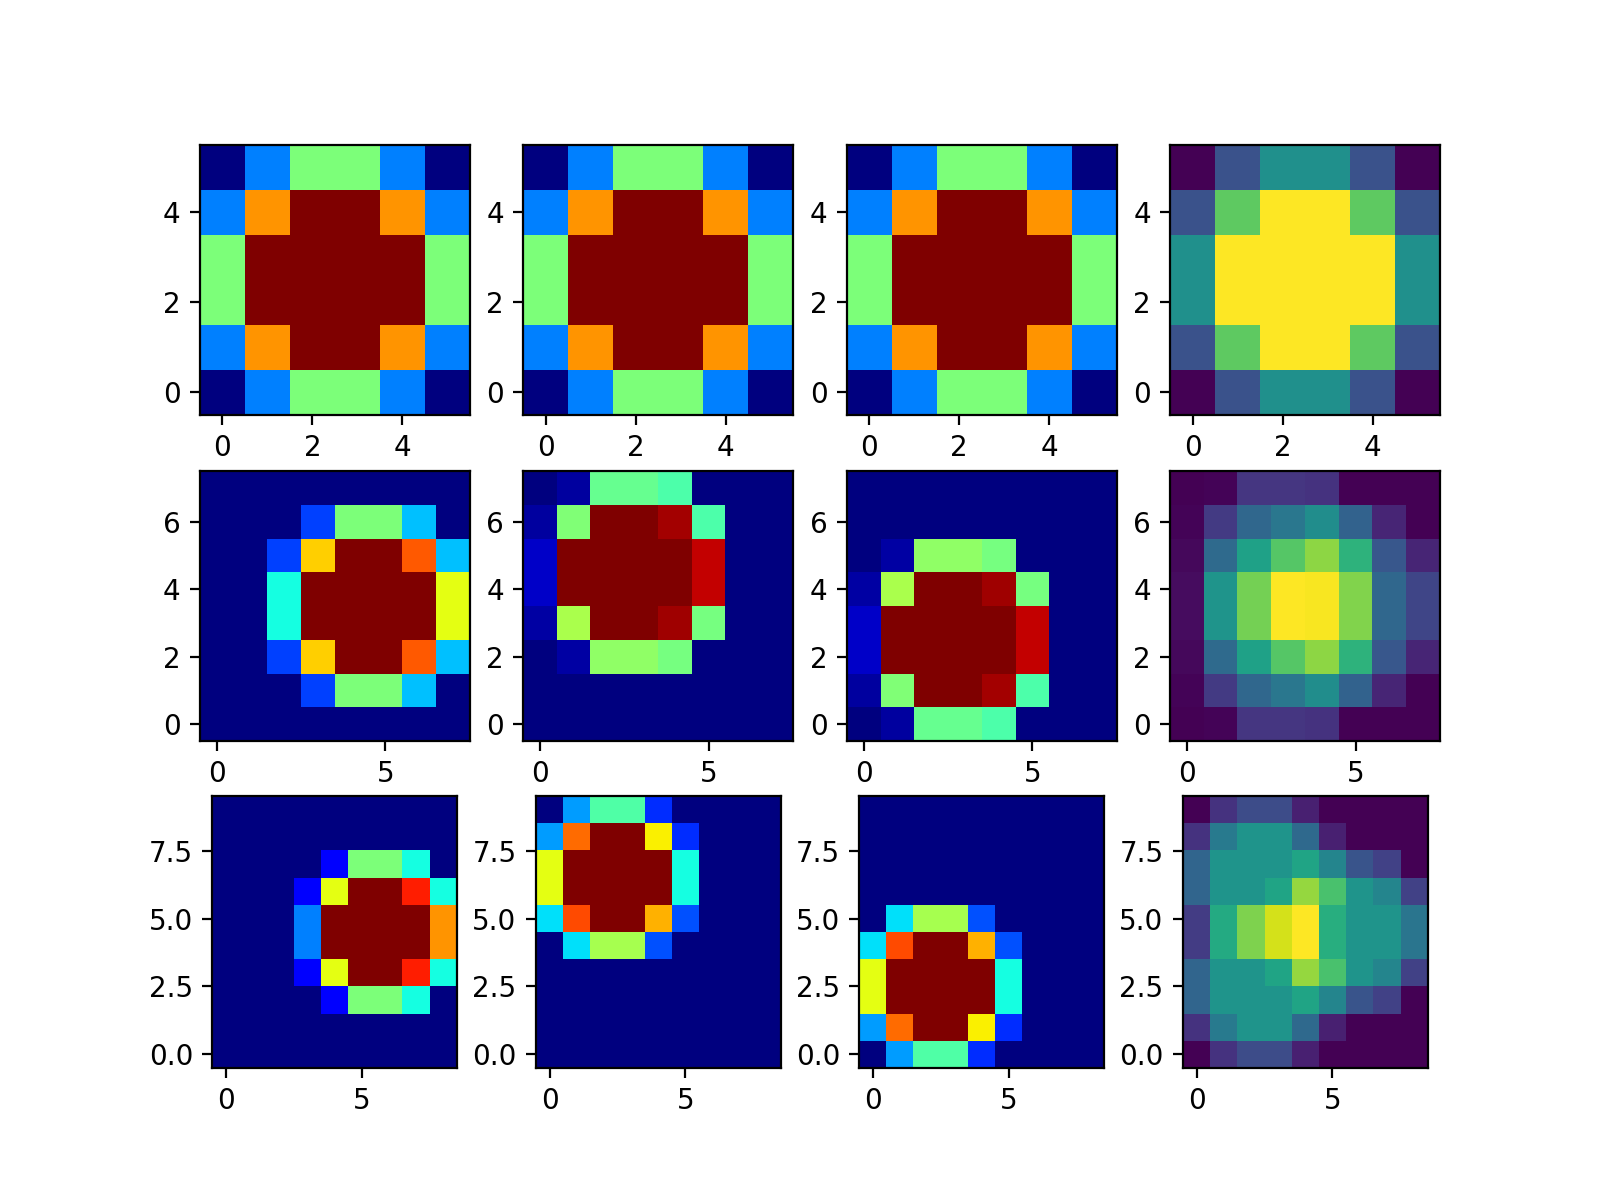

In [363]:
if verbose:
    fig3=pyp.figure(3,figsize=(2*(reconGeometry.nAzi+1),2*reconGeometry.nLayers))
    sps=fig3.subplots(reconGeometry.nLayers,reconGeometry.nAzi+1)
    for layerN in range(reconGeometry.nLayers):
        for aziN in range(reconGeometry.nAzi):
            sps[layerN,aziN].imshow(reconGeometry.layerMasks[layerN][aziN], cmap='jet' )
        sps[layerN,aziN+1].imshow(reconGeometry.layerMasks[layerN][:aziN+1].sum(0))


Projection generation,
* Extraction of projected mask through layers in reconstruction geometry, `reconExM`,
* Vertical sum of projected mask, `sumPrM`,
* Conversion between illuminated-only layer vector and entire (rectangular support) layer vector, `reconTrimIdx`,

Two types here, for reconstruction and for (input) data.

In [347]:
# projection matrices
layerExM=reconGeometry.layerExtractionMatrix()
sumPrM=reconGeometry.sumProjectedMatrix()
reconTrimIdx=reconGeometry.trimIdx()
sumLayerExM=sumPrM@(layerExM.take(reconTrimIdx,axis=1))
sumLayerExM=modalCoeffsAllM@sumLayerExM # modal coefficients

# actualLayerExM,actualSumPrM,actualTrimIdx,actualSumLayerExM=\
#       layerExM,sumPrM,reconTrimIdx,sumLayerExM
actualLayerExM=actualGeometry.layerExtractionMatrix()
actualSumPrM=actualGeometry.sumProjectedMatrix()
actualTrimIdx=actualGeometry.trimIdx()
actualSumLayerExM=actualSumPrM@actualLayerExM.take(actualTrimIdx,axis=1)
actualSumLayerExM=modalCoeffsAllM@actualSumLayerExM

actualAveragingM=numpy.zeros([nModes, nModes*nAzi], numpy.float64)
for i in range(nAzi):
    actualAveragingM[:,i*nModes:(i+1)*nModes]=numpy.identity(nModes)*nAzi**-1.0

<IPython.core.display.Javascript object>


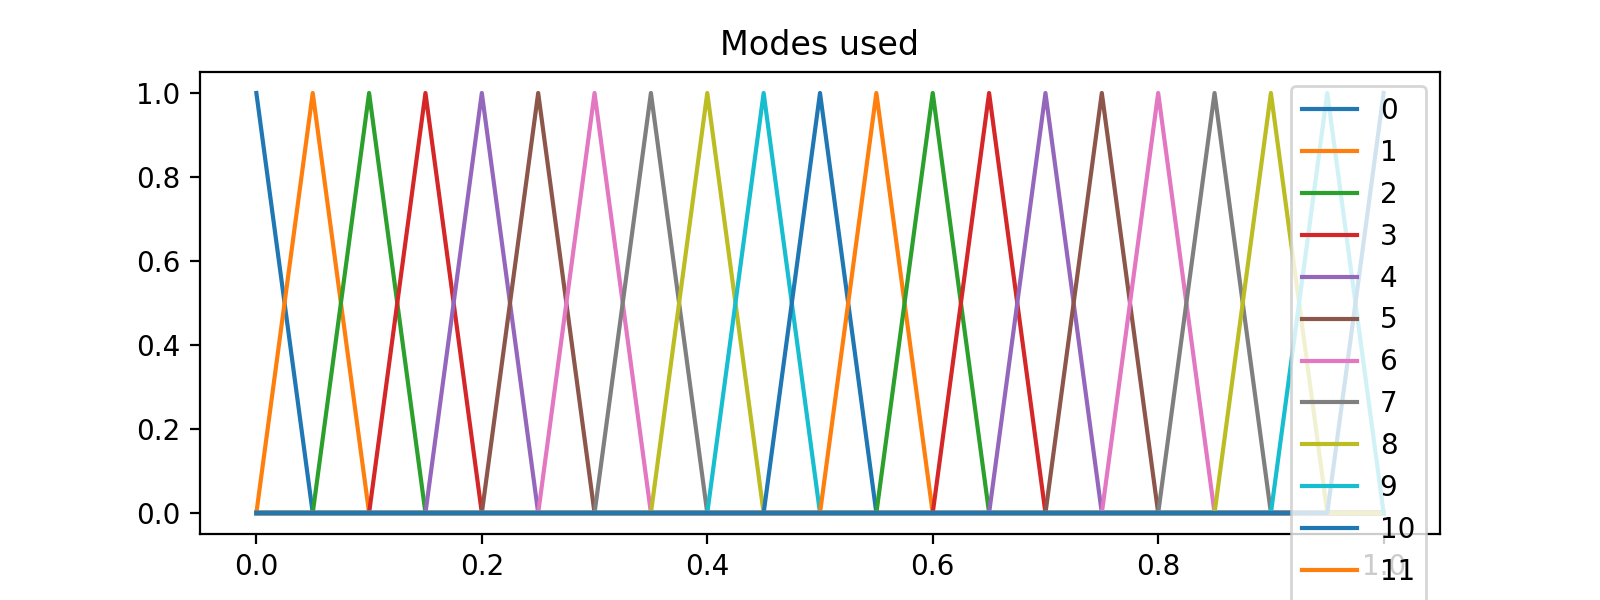

In [364]:
if verbose:
    pyp.figure(2,figsize=(8,3))
    for i,mode in enumerate(modalCoefficientsM):
        pyp.plot( numpy.linspace(0,1,nMask), mode,label=str(i) )
    pyp.title("Modes used")
    pyp.legend()

Generation of data.

In [349]:
weights=numpy.ones(actualGeometry.nLayers) #numpy.random.uniform(0,1,size=100)).tolist()
if verbose:
    print("Per layer weighting for i/p data:\n\tmean is {:f}, variance is {:f}".format(
        numpy.mean(weights), numpy.var(weights)))

print("Input data...",end="") ; sys.stdout.flush()

inputData=[]
inputDataV=[]
for j in range(reps):
    thisInputDataV=[]
    thisInputData=[]
    for i in range(actualGeometry.nLayers):
        tS=actualGeometry.layerNpix[i]
        thisData=kolmogorov.TwoScreens(tS.max()*2, (nMask**0.5)/2.0)[0][:tS[0],:tS[1]]
        thisInputData.append( 2*(thisData-thisData.mean())/(thisData.max()-thisData.min()) ) # normalize
        thisInputData[i]*=weights[i] # scale
        thisInputDataV+=thisInputData[i].ravel().tolist() # vectorize
    inputData.append( thisInputData )
    inputDataV.append( thisInputDataV )
    print("{:d}.".format(j+1),end="") ; sys.stdout.flush()
    

#inputDataA=[ numpy.ma.masked_array(inputData[i], actualGeometry.layerMasks[i].sum(axis=0)==0)
#            for i in range(actualGeometry.nLayers) ]

print("(done)") ; sys.stdout.flush()

Per layer weighting for i/p data:
	mean is 1.000000, variance is 0.000000
Input data...1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.2

In [365]:
# calculate input vector
inputDataV=numpy.array( inputDataV )
randomExVs=numpy.take( inputDataV, actualTrimIdx, 1 ).T
#randomExV=numpy.take( inputDataV, actualTrimIdx )
#randomProjV=numpy.dot( actualSumLayerExM, randomExV )
randomProjVs=actualSumLayerExM@randomExVs
print("All data prepared") ; sys.stdout.flush()

averagedProjVs=actualAveragingM@randomProjVs
if verbose:
    #print("Shapes of inputDataV,randomExVs,actualSumLayerExM:",inputDataV.shape,randomExVs.shape,actualSumLayerExM.shape)
    print("    randomExVs.shape="+str(randomExVs.shape))
    print("  randomProjVs.shape = "+str(randomProjVs.shape))
    print("      Expected shape = ({:d}, {:d})".format(nAzi*nModes,reps))
    print("averagedProjVs.shape="+str(averagedProjVs.shape))

All data prepared
    randomExVs.shape=(158, 1000)
  randomProjVs.shape = (6, 1000)
      Expected shape = (63, 1000)
averagedProjVs.shape=(2, 1000)


Build reconstructor

In [366]:
weights*=1 # bodge
# now, try straight inversion onto the illuminated portions of the layers 
sTs=sumLayerExM.T@sumLayerExM

layerInsertionIdx=reconGeometry.trimIdx(False)
regularisationM=numpy.zeros([layerInsertionIdx[-1][0]]*2)

if "sTs_invSVD" in dir():
    del sTs_invSVD
if "sTs_invR" in dir():
    del sTs_invR
    
print("Reconstructor type is:",end="")
if regularizationType=='naive':
    # \/ Tikhonov regularisation
    print("Naive")
    for i in range(reconGeometry.nLayers):
        diagIdx=numpy.arange( layerInsertionIdx[i][0],layerInsertionIdx[i+1][0] ) *(layerInsertionIdx[-1][0]+1)
        regularisationM.ravel()[diagIdx]=1
# elif regularizationType=='intermediate':
#     # \/ Intermediate layer restriction
#     print("Intermediate-layer restriction...",end="") ; sys.stdout.flush()
#     layerMapping=[]
#     for actualLh in actualGeometry.layerHeights:
#         i=reconGeometry.layerHeights.searchsorted(actualLh)
#         if i==reconGeometry.nLayers: continue # can't do this one
#         layerMapping.append([actualLh,i])
#         layerMapping[-1].append(
#          (reconGeometry.layerHeights[i]-actualLh
#             )/(reconGeometry.layerHeights[i]-reconGeometry.layerHeights[i-1]))

#     regularisationD=numpy.ones(layerInsertionIdx[-1][0])*1e-12
#      # \/ fill diagonal roughly 
#     for lm in layerMapping:
#         diagIdx=numpy.arange(layerInsertionIdx[lm[1]][0],layerInsertionIdx[lm[1]+1][0])
#         regularisationD[diagIdx]=(1-lm[-1])**2.0*(weights[lm[1]]**2.0) # add weighting
#         if lm[-1]!=0: # add to corresponding points in layer below
#             diagIdx=numpy.arange(layerInsertionIdx[lm[1]-1][0],layerInsertionIdx[lm[1]][0])
#             regularisationD[diagIdx]+=(lm[-1])**2.0*(weights[lm[1]]**2.0)

#     regularisationM.ravel()[
#          numpy.arange(layerInsertionIdx[-1][0])*(layerInsertionIdx[-1][0]+1)]=\
#             1e-3*regularisationD**-0.5
elif regularizationType=='laplacian':
    print("Bi-harmonic approximation",end="")
    offset=0
    for i in range(reconGeometry.nLayers):
        tlO=gradientOperator.laplacianOperatorType1(
             pupilMask=reconGeometry.layerMasks[i].sum(axis=0) ).returnOp()
        print((i,offset,tlO.shape[0]),end="")
        regularisationM[offset:offset+tlO.shape[0],offset:offset+tlO.shape[0]]=\
                   1e-3*tlO.dot(tlO.T)*weights[i]**-2.0
        offset+=tlO.shape[0]

if regularizationType=='SVD':
    # \/ SVD approach
    usePinv=True
    print("SVD",end="") ; sys.stdout.flush()
    sTs_invSVD=numpy.linalg.pinv( sTs, rcond=1e-3 ) # pinv version
    u,s,vT=numpy.linalg.svd(sTs)
else:
    if regularisationM.var()==0:
        raise ValueError("Regularisation is zero, was it forgot?")
    print("...inverting",end="") ; sys.stdout.flush()
    sTs_invR=numpy.linalg.inv(sTs + regularisationM ) 
print("\n(done)") ; sys.stdout.flush()

# \/ choose inversion method
if "sTs_invSVD" in dir():
    sTs_inv=sTs_invSVD
elif "sTs_invR" in dir():
    print("Using regularisation")
    sTs_inv=sTs_invR
if 'sTs_inv' not in dir():
    raise ValueError("Did you forget to enable a matrix?")

Reconstructor type is:Bi-harmonic approximation(0, 0, 32)(1, 32, 54)(2, 86, 72)...inverting
(done)
Using regularisation


<IPython.core.display.Javascript object>


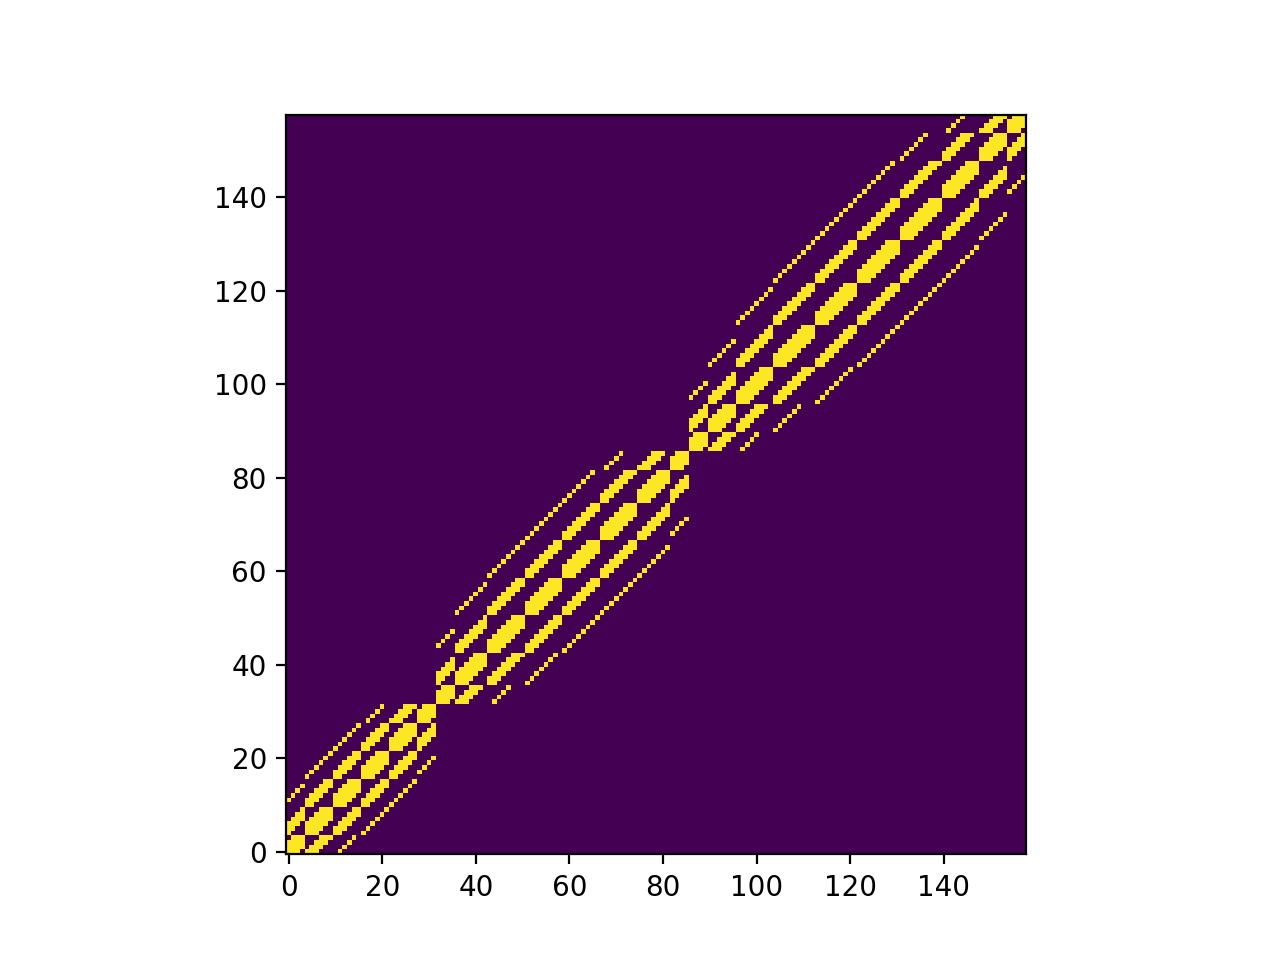

In [367]:
pyp.figure(99)
pyp.imshow(regularisationM!=0)

Reconstruct _fully_ sampled vector

In [368]:
recoveryM=sTs_inv@sumLayerExM.transpose()
recoveredVs=recoveryM@randomProjVs
if verbose:
    print("recoveryM has shape "+str(recoveryM.shape))
    print("recoveredVs has shape"+str(recoveredVs.shape))

recoveryM has shape (158, 6)
recoveredVs has shape(158, 1000)


In [369]:
# recoveredLayersA=[
#    numpy.ma.masked_array(
#       numpy.zeros(reconGeometry.layerNpix[i], numpy.float64),
#       reconGeometry.layerMasks[i].sum(axis=0)==0)
#       for i in range(reconGeometry.nLayers) ]

# for i in range(reconGeometry.nLayers):
#     recoveredLayersA[i].ravel()[layerInsertionIdx[i][1]]=\
#        recoveredV[layerInsertionIdx[i][0]:layerInsertionIdx[i+1][0]]
#     recoveredLayersA[i]-=recoveredLayersA[i].mean()

Centre projection of reconstruction and data, converting to modal amplitudes

In [370]:
# centre projected values
reconCentreProjM=reconGeometry.layerCentreProjectionMatrix().take(
   reconTrimIdx, axis=1 )
actualCentreProjM=actualGeometry.layerCentreProjectionMatrix().take(
   actualTrimIdx, axis=1 )
centreRecoveredVs=reconCentreProjM@recoveredVs
inputCentreVs=actualCentreProjM@randomExVs

nLayers=actualGeometry.nLayers
modalCoeffsLayersM=numpy.zeros(
         [nModes*nLayers, nMask*nLayers], numpy.float64)
for i in range(nLayers): # nAzi directions modal basis operator
    modalCoeffsLayersM[nModes*i:nModes*(i+1),nMask*i:nMask*(i+1)]=modalCoefficientsM

centreRecoveredModesVs=modalCoeffsLayersM@centreRecoveredVs
inputCentreModesVs=modalCoeffsLayersM@inputCentreVs

centreRecoveredModesAmps=centreRecoveredModesVs.reshape([nLayers,nModes,reps])
inputCentreModesAmps=inputCentreModesVs.reshape([nLayers,nModes,reps])

In [371]:
if verbose:
    print("   reconCentreProjM.shape={0[0]:d},{0[1]:d}".format(reconCentreProjM.shape))
    print("    modalCoeffsAllM.shape={0[0]:d},{0[1]:d}".format(modalCoeffsAllM.shape))
    print(" modalCoeffsLayersM.shape={0[0]:d},{0[1]:d}".format(modalCoeffsLayersM.shape))
    print(" modalCoefficientsM.shape={0[0]:d},{0[1]:d}".format(modalCoefficientsM.shape))
    print("     centreRecoveredVs.shape={0[0]:d},{0[1]:d}".format(centreRecoveredVs.shape))
    print("         inputCentreVs.shape={0[0]:d},{0[1]:d}".format(inputCentreVs.shape))
    print("centreRecoveredModesVs.shape={0[0]:d},{0[1]:d}".format(centreRecoveredModesVs.shape))
    print("    inputCentreModesVs.shape={0[0]:d},{0[1]:d}".format(inputCentreModesVs.shape))
    print("nLayers={0:d}".format(nLayers))
    print("nModes={:d}".format(nModes))
    print("nMask={:d}".format(nMask))
    print("reps={:d}".format(reps))

numpy.set_printoptions(precision=2)
if reps<2:
    print("Centre-projected recon. mode amps:\n{:s}".format(str(centreRecoveredModesAmps)))
    print("  Data centre-projected mode amps:\n{:s}".format(str(inputCentreModesAmps)))

print("Centre-projected recon. summed amps:\n{:s}".format(str(centreRecoveredModesAmps.sum(0))))
print("  Data centre-projected summed amps:\n{:s}".format(str(inputCentreModesAmps.sum(0))))
centreDataLessReconAmps=inputCentreModesAmps-centreRecoveredModesAmps
centreReconRelDataAmps=numpy.log(abs(inputCentreModesAmps))-numpy.log(abs(centreRecoveredModesAmps))
print("Centre-projected, layer-summed (data-recon.) amps:\n<diff.>={:s},\n   s.d.={:s}".format(
        str(centreDataLessReconAmps.sum(0).mean(1)),
        str(centreDataLessReconAmps.sum(0).std(1)),
           ))
print("Centre-projected, (recon.-data) amps:\n<diff.>={:s},\n   s.d.={:s}".format(
        str(centreDataLessReconAmps.mean(2)),
        str(centreDataLessReconAmps.std(2)),
           ))
print("Centre-projected, (ln{{recon.}}-ln{{data}}) amps:\n<rel.>={:s},\n   s.d.={:s}".format(
        str(centreReconRelDataAmps.mean(2)),
        str(centreReconRelDataAmps.std(2)),
           ))

# [nLayers,nModes,reps] is the shape of the 'Amps' variables

   reconCentreProjM.shape=63,158
    modalCoeffsAllM.shape=63,63
 modalCoeffsLayersM.shape=63,63
 modalCoefficientsM.shape=21,21
     centreRecoveredVs.shape=63,1000
         inputCentreVs.shape=63,1000
centreRecoveredModesVs.shape=63,1000
    inputCentreModesVs.shape=63,1000
nLayers=3
nModes=21
nMask=21
reps=1000
Centre-projected recon. summed amps:
[[-0.28 -1.17  0.02 ... -0.84  1.36  0.98]
 [-0.22 -1.16  0.41 ... -0.59  1.57  1.1 ]
 [-0.15 -1.08  0.62 ... -0.2   1.43  0.74]
 ...
 [-0.83 -0.    0.26 ...  0.43 -0.44  0.01]
 [-0.55  0.55  0.75 ...  0.58 -0.64 -0.5 ]
 [-0.25  0.66  0.96 ...  0.54 -0.73 -0.86]]
  Data centre-projected summed amps:
[[-0.15 -0.13 -0.4  ... -1.02  1.06  0.89]
 [ 0.28 -0.05 -0.08 ... -0.58  1.41  0.62]
 [ 0.53 -0.22  0.39 ... -0.2   1.25  0.43]
 ...
 [-0.29  0.43 -0.37 ...  0.12 -0.41  0.45]
 [-0.22  0.97 -0.22 ...  0.15 -0.69  0.  ]
 [-0.17  1.62  0.2  ...  0.32 -0.96 -0.82]]
Centre-projected, layer-summed (data-recon.) amps:
<diff.>=[-0.01 -0.01 -0.02 -0.0

<IPython.core.display.Javascript object>


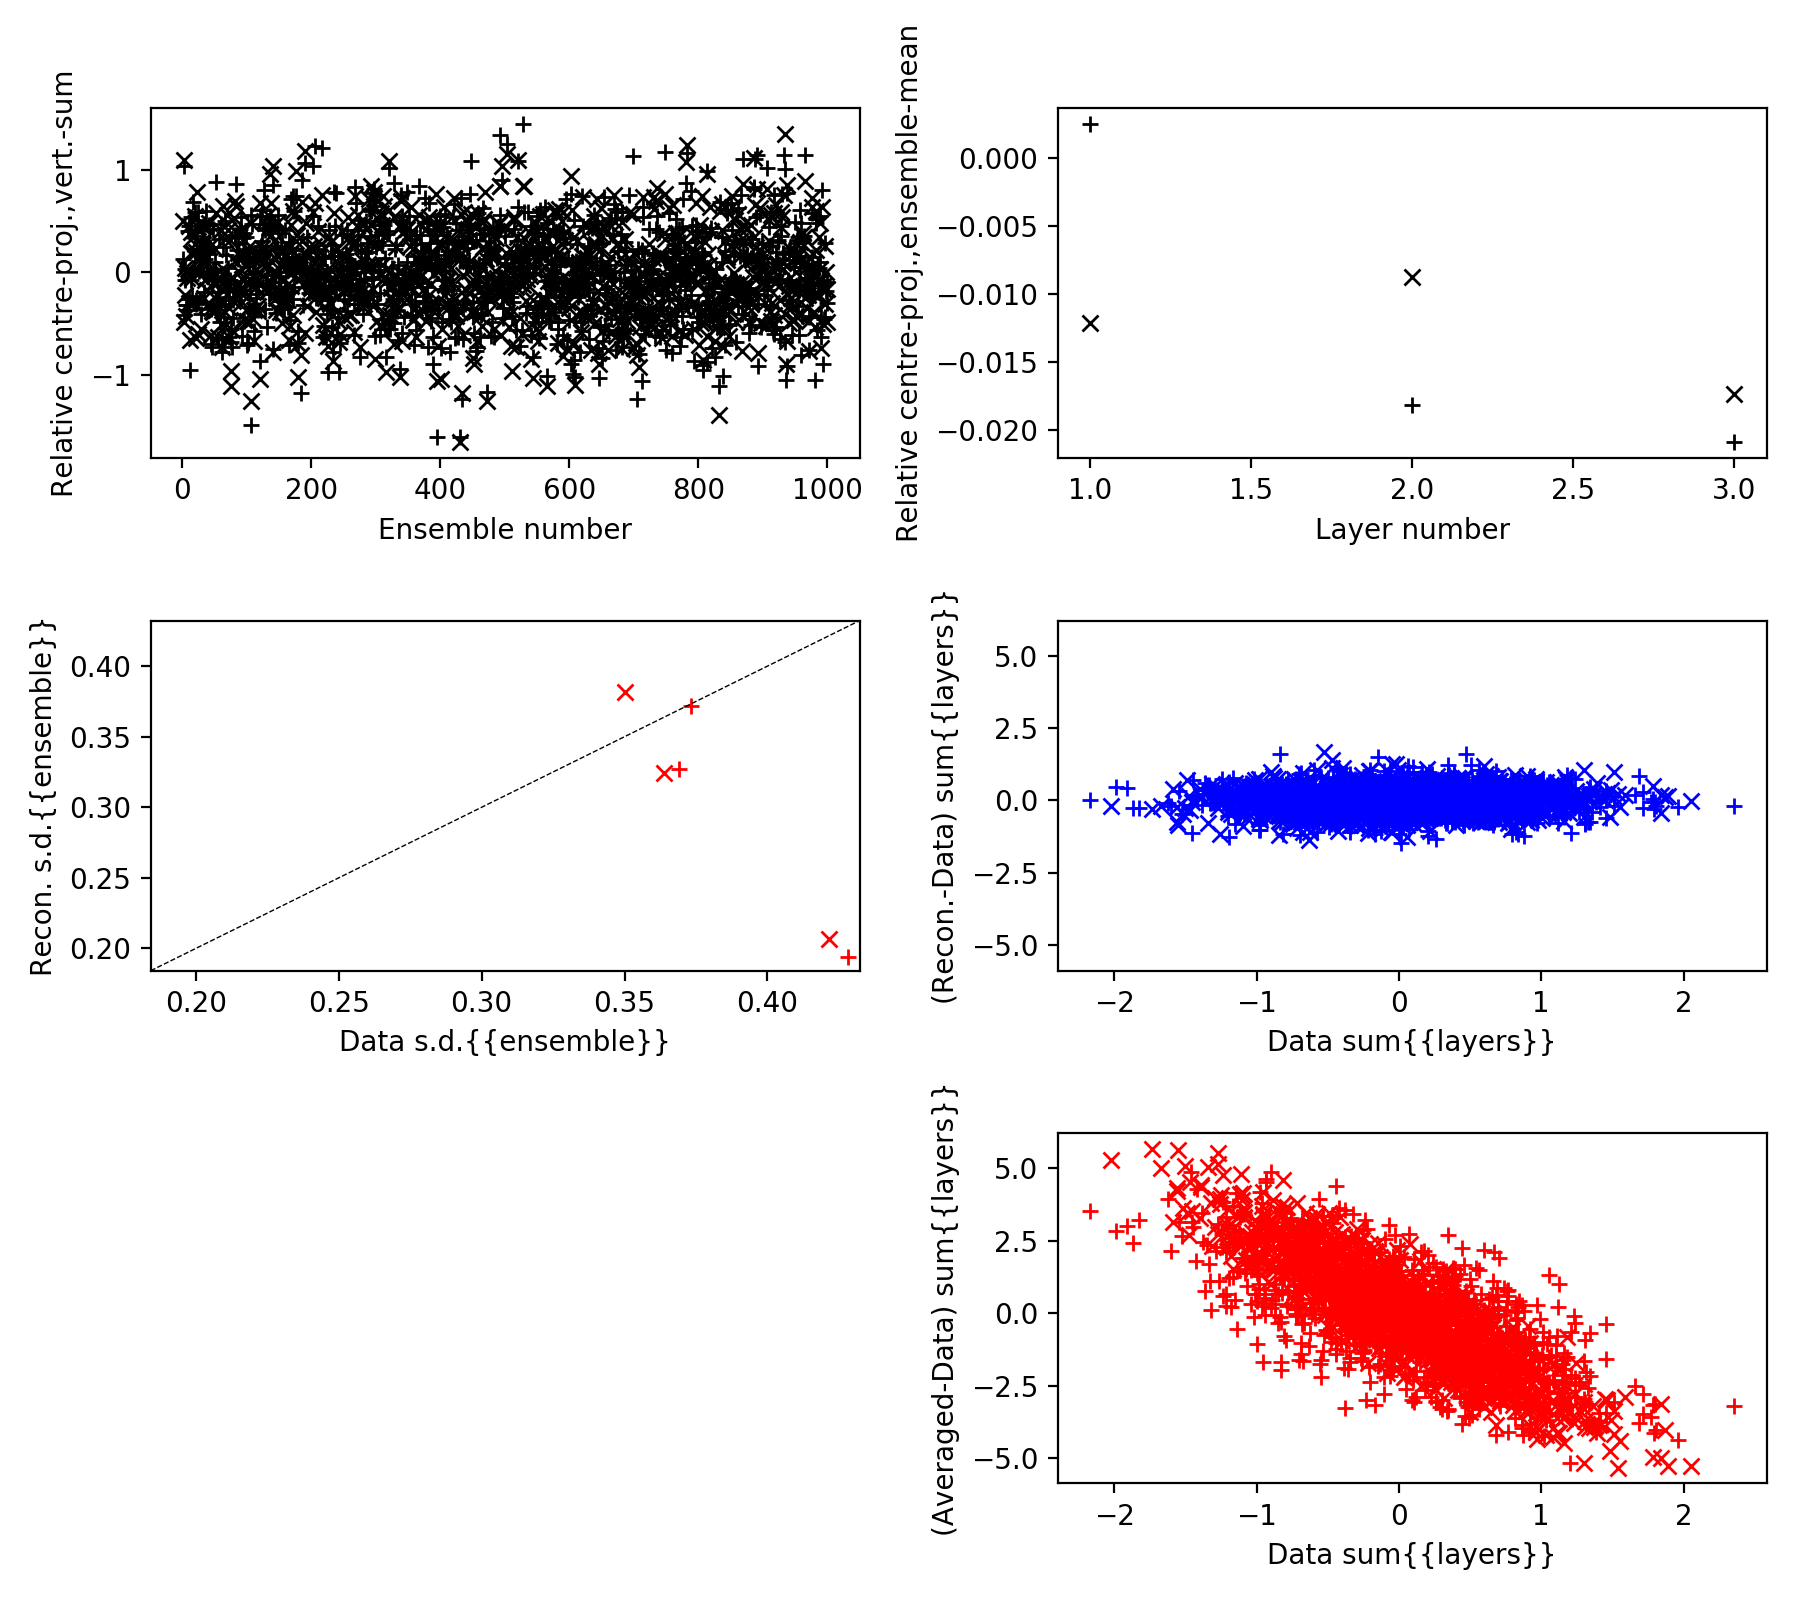

In [372]:
fig101=pyp.figure(101,figsize=(9,8))
sp101_221=pyp.subplot(3,2,1)
sp101_222=pyp.subplot(3,2,2)
sp101_223=pyp.subplot(3,2,3)
sp101_224=pyp.subplot(3,2,4)
sp101_326=pyp.subplot(3,2,6)

In [373]:
symbols=['+','x','^','d']
relativeDlRPerMember=centreDataLessReconAmps.sum(0)#/centreDataLessReconAmps.sum(0).std(1).reshape([nModes,1])
for i,symb in enumerate(symbols[:2 if nModes>4 else nModes]):
    sp101_221.plot( numpy.arange(1,reps+1), relativeDlRPerMember[i],'k'+symb ) # data vs. recon, summed (-> ensemble-centric)
sp101_221.set_xlabel("Ensemble number")
sp101_221.set_ylabel("Relative centre-proj.,vert.-sum")

symbols=['+','x','^','d']
#relativeDlRPerLayer=centreDataLessReconAmps.mean(2)/centreDataLessReconAmps.sum(0).std(1).reshape([1,nModes])
relativeDlRPerLayer=centreDataLessReconAmps.mean(2)/inputCentreModesAmps.std(2)
for i,symb in enumerate(symbols[:2 if nModes>4 else nModes]):
    sp101_222.plot( numpy.arange(1,nLayers+1), relativeDlRPerLayer[:,i],'k'+symb ) # data vs. recon, summed (-> layer-centric)
sp101_222.set_xlabel("Layer number")
sp101_222.set_ylabel("Relative centre-proj.,ensemble-mean")

symbols=['+','x','^','d']
relativeDAmps=inputCentreModesAmps.std(2).T # transpose means [nModes,nLayers] shape
relativeRAmps=centreRecoveredModesAmps.std(2).T
for i,symb in enumerate(symbols[:2 if nModes>4 else nModes]):
    sp101_223.plot( relativeDAmps[i],relativeRAmps[i],'r'+symb ) # data vs. recon, summed (-> layer-centric)
sp101_223.set_xlabel("Data s.d.{{ensemble}}")
sp101_223.set_ylabel("Recon. s.d.{{ensemble}}")
limits=[
        min(min(sp101_223.get_xlim()),min(sp101_223.get_ylim())),
        max(max(sp101_223.get_xlim()),max(sp101_223.get_ylim()))]
sp101_223.set_xlim(limits)
sp101_223.set_ylim(limits)
sp101_223.plot(limits,limits,'k--',lw=0.5)

# symbols=['+','x','^','d']
# #inputCentreModesAmps,centreRecoveredModesAmps
# relativeDlRFirstPerMember=centreDataLessReconAmps[0]/inputCentreModesAmps[0].std(1).reshape([nModes,1])
# for i,symb in enumerate(symbols[:nModes]):
#     sp101_224.plot( numpy.arange(1,reps+1), relativeDlRFirstPerMember[i],'b'+symb ) # data vs. recon,1st layer (-> ensemble-centric)
# sp101_224.set_xlabel("Ensemble number")
# sp101_224.set_ylabel("Relative centre-proj.,1st layer")
symbols=['+','x','^','d']
relativeSDAmps=inputCentreModesAmps.sum(0) # [nModes,nLayers] shape
relativeSRAmps=centreRecoveredModesAmps.sum(0)
for i,symb in enumerate(symbols[:2 if nModes>4 else nModes]):
    sp101_224.plot( relativeSDAmps[i],relativeSRAmps[i]-relativeSDAmps[i],'b'+symb ) # data vs. recon, summed (-> layer-centric)
sp101_224.set_xlabel("Data sum{{layers}}")
sp101_224.set_ylabel("(Recon.-Data) sum{{layers}}")
# limits=[
#         min(min(sp101_224.get_xlim()),min(sp101_224.get_ylim())),
#         max(max(sp101_224.get_xlim()),max(sp101_224.get_ylim()))]
# sp101_224.set_xlim(limits)
# sp101_224.set_ylim(limits)
# sp101_224.plot(limits,limits,'k--',lw=0.5)

averagedDAmps=averagedProjVs # [nModes,nLayers] shape
for i,symb in enumerate(symbols[:2 if nModes>4 else nModes]):
    sp101_326.plot( relativeSDAmps[i],averagedDAmps[i]-relativeSDAmps[i],'r'+symb ) # data vs. recon, summed (-> layer-centric)
sp101_326.set_xlabel("Data sum{{layers}}")
sp101_326.set_ylabel("(Averaged-Data) sum{{layers}}")
# limits=[ min(min(sp101_326.get_xlim()),min(sp101_326.get_ylim())),
#          max(max(sp101_326.get_xlim()),max(sp101_326.get_ylim())) ]
sp101_224.set_ylim( sp101_326.get_ylim() )
# sp101_326.set_xlim(limits)
# sp101_326.set_ylim(limits)
# sp101_326.plot(limits,limits,'k--',lw=0.5)

pyp.tight_layout()

Check that the cross-correlation of modes between layers is the expected diagonal

<IPython.core.display.Javascript object>


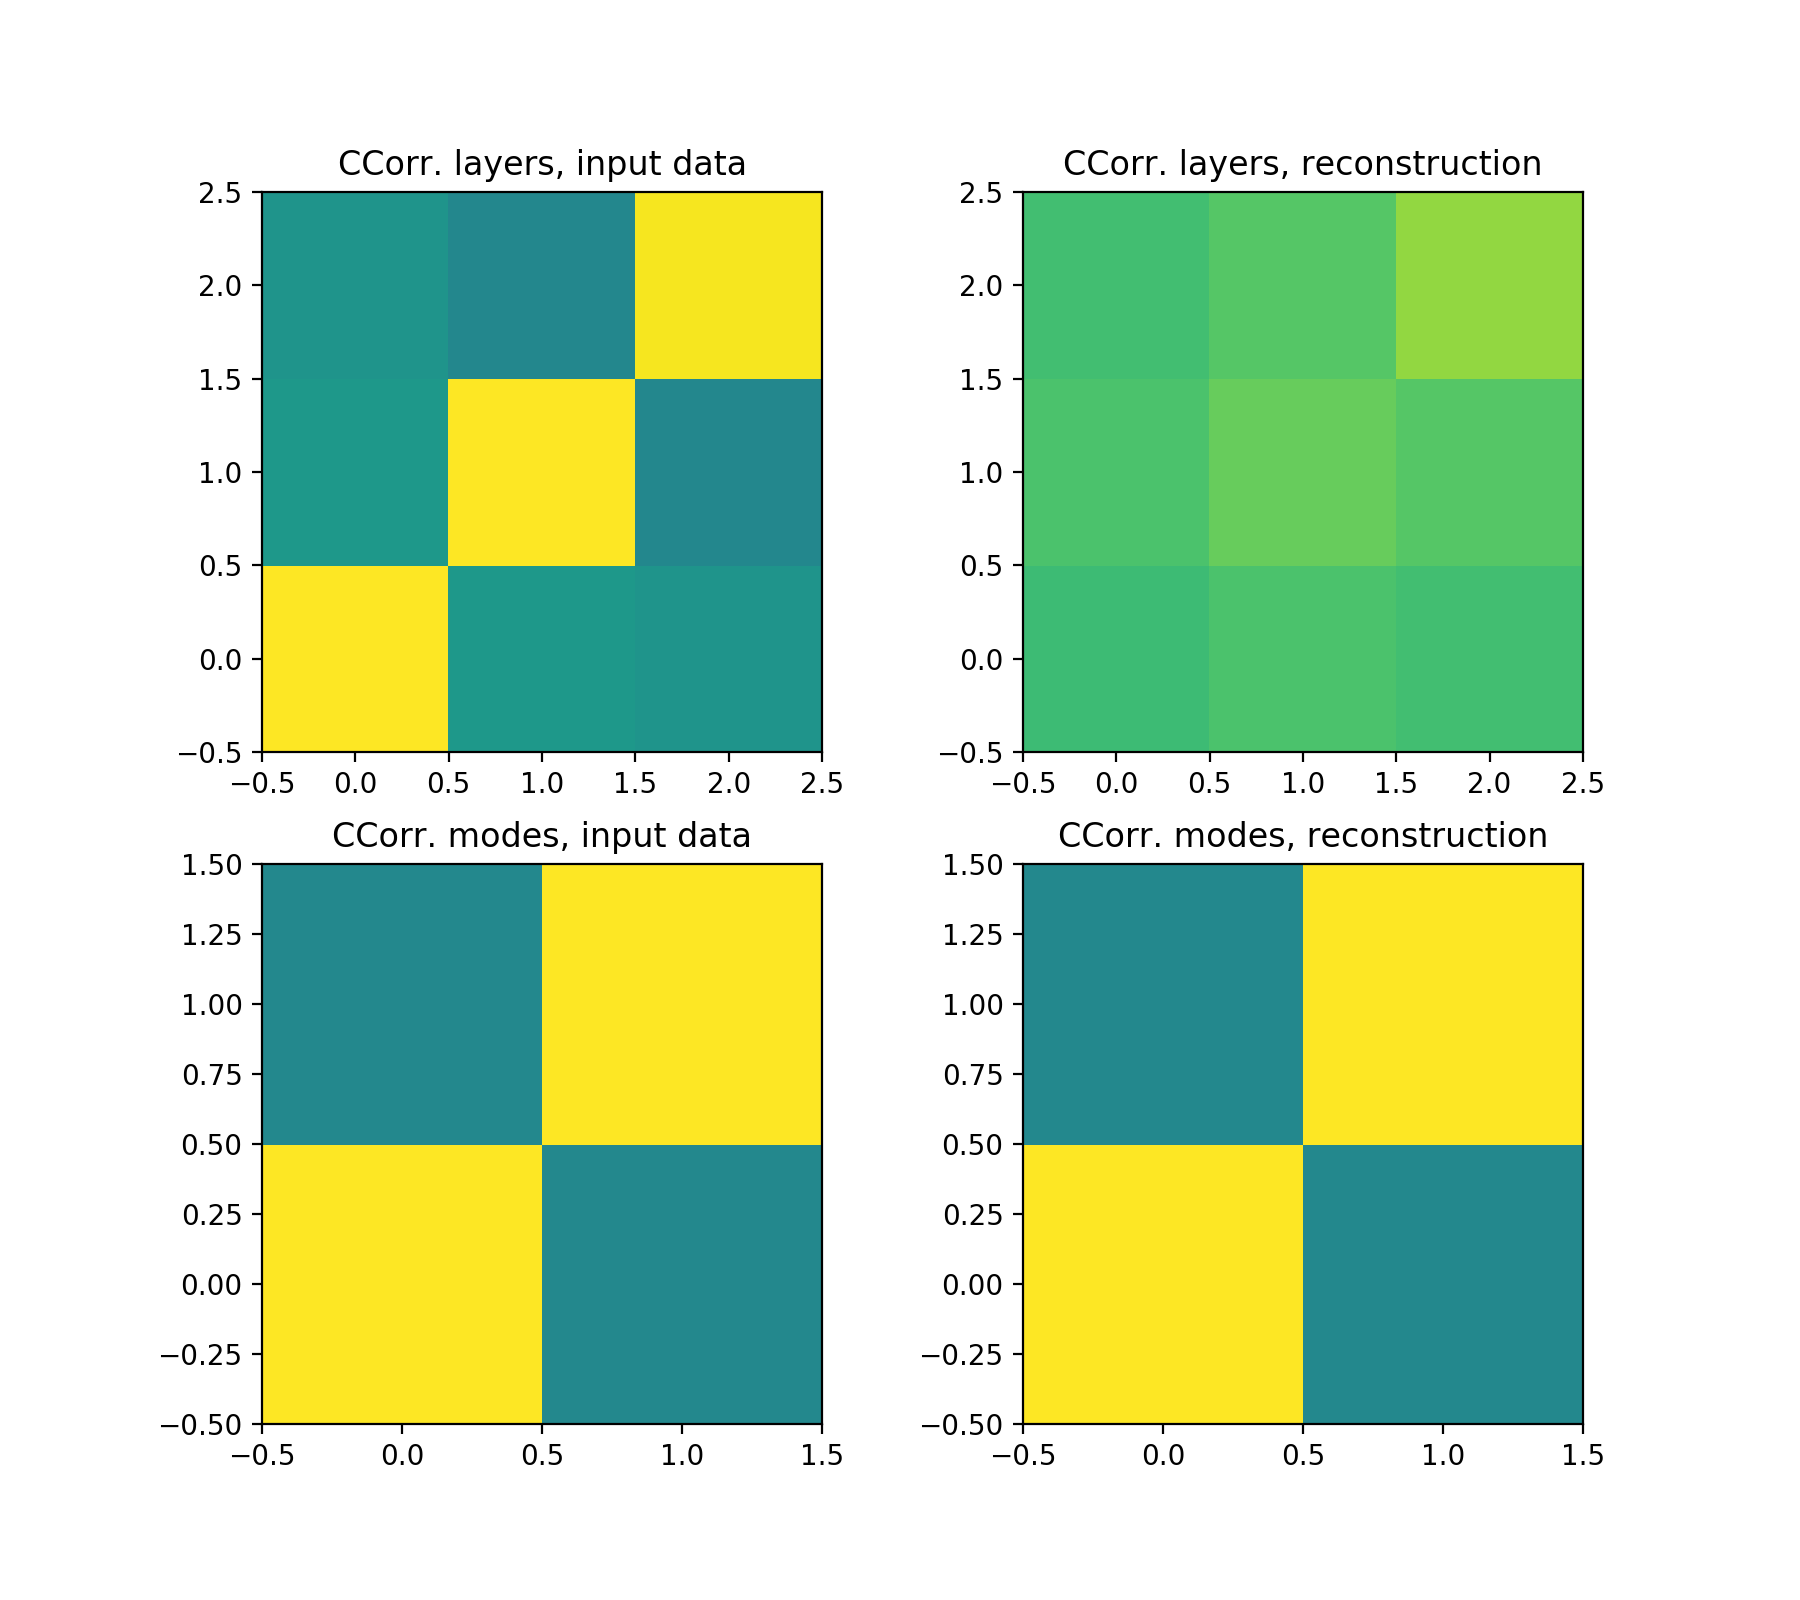

In [53]:
fig102=pyp.figure(102,figsize=(9,8))
sp102_221=pyp.subplot(2,2,1)
sp102_222=pyp.subplot(2,2,2)
sp102_223=pyp.subplot(2,2,3)
sp102_224=pyp.subplot(2,2,4)

In [54]:
print(inputCentreModesAmps.T.swapaxes(1,2).shape,inputCentreModesAmps.T.shape)
ccLayersDataModesM=( inputCentreModesAmps.T.swapaxes(1,2) @ inputCentreModesAmps.T ).mean(0)
ccLayersReconModesM=( centreRecoveredModesAmps.T.swapaxes(1,2) @ centreRecoveredModesAmps.T ).mean(0)
ccModesDataModesM=( inputCentreModesAmps.sum(0) @ inputCentreModesAmps.sum(0).T )/reps
ccModesReconModesM=( centreRecoveredModesAmps.sum(0) @ centreRecoveredModesAmps.sum(0).T )/reps

sp102_221.imshow( ccLayersDataModesM, vmax=ccLayersDataModesM.ptp()/2.0,  vmin=-ccLayersDataModesM.ptp()/2.0 )
sp102_221.set_title("CCorr. layers, input data")
sp102_222.imshow( ccLayersReconModesM, vmax=ccLayersDataModesM.ptp()/2.0,  vmin=-ccLayersDataModesM.ptp()/2.0 )
sp102_222.set_title("CCorr. layers, reconstruction")
#
sp102_223.imshow( ccModesDataModesM, vmax=ccModesDataModesM.ptp()/2.0,  vmin=-ccModesDataModesM.ptp()/2.0 )
sp102_223.set_title("CCorr. modes, input data")
sp102_224.imshow( ccModesReconModesM, vmax=ccModesDataModesM.ptp()/2.0,  vmin=-ccModesDataModesM.ptp()/2.0 )
sp102_224.set_title("CCorr. modes, reconstruction")

(100, 3, 2) (100, 2, 3)


Text(0.5, 1.0, 'CCorr. modes, reconstruction')